### The idea behind this notebook:
Fit the analytical model to the data from Manu and use those models to generate the synthetic FEM.

In [24]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad, jacrev
from jax.lax import cond, scan
import jax.random as random
key = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree
from jax.sharding import PositionalSharding
from scipy.optimize import minimize
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd

from utils import train, coords_2_strain_nn
from utils import train_colloc_parallel as train_colloc, init_params_nn, ff_nn, divergence, bd_forces, a1, a2, lr
from utils_hyperelasticity import NODE, init_layers, NODE_model_aniso, init_params_aniso, GOH_model, eval_Cauchy, eval_Cauchy_vmap, eval_P, eval_P_vmap
from utils_hyperelasticity import ThreeDElasticity, neohook_model
from fem import plotmesh, fe_solver_2D, vahid_anisohyper_inv, apply_bc_biax

from jax_fem.core import FEM
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh, get_meshio_cell_type, Mesh, rectangle_mesh

from PIL import Image, ImageFilter
from jaxinterp2d import interp2d

E_fun = vmap(lambda F: 0.5*(F.T@F - jnp.eye(2)))

### 0. Analyze the homogeneous material data

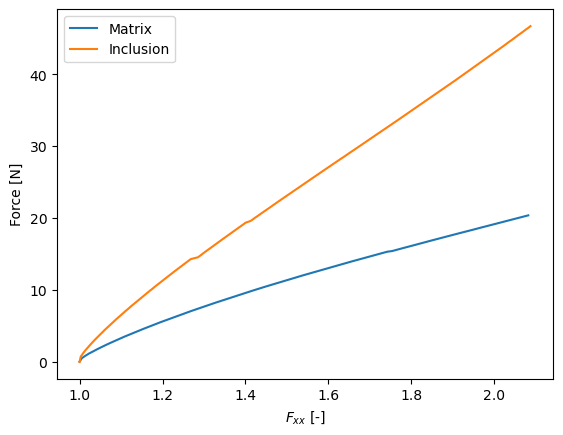

In [2]:
with open('data/manu/soft_homo.npy', 'rb') as f:
    x,y,F_hist_mtrx,force_mtrx = pickle.load(f)
F_hist_mtrx = F_hist_mtrx.mean(axis=1)

with open('data/manu/stiff2_homo.npy', 'rb') as f:
    x,y,F_hist_incl,force_incl = pickle.load(f)
F_hist_incl = F_hist_incl.mean(axis=1)

fig, ax = plt.subplots()
ax.plot(F_hist_mtrx[:,1,1], force_mtrx, label='Matrix')
ax.plot(F_hist_incl[:,1,1], force_incl, label='Inclusion')
ax.set(xlabel='$F_{xx}$ [-]', ylabel='Force [N]')
ax.legend(); 

In [33]:
# Train neo Hookean material model with these two datasets
ugrad_incl = F_hist_incl - np.eye(2)
ugrad_mtrx = F_hist_mtrx - np.eye(2)

get_neohook_stress = lambda ugrad, params : ThreeDElasticity(neohook_model).ugrad_2_P(ugrad, params, 2)[1,1]
get_neohook_vmap = vmap(get_neohook_stress, in_axes=(0, None))
def loss(params, ugrad_vec, P_gt):
    P_pr = get_neohook_vmap(ugrad_vec, params)
    return jnp.mean((P_pr-P_gt)**2)

mu_0 = jnp.array([0.0])
loss_incl = lambda params: loss(params, ugrad_incl, force_incl)
loss_mtrx = lambda params: loss(params, ugrad_mtrx, force_mtrx)
params_incl = minimize(loss_incl, mu_0, jac = grad(loss_incl), method='Newton-CG').x
params_mtrx = minimize(loss_mtrx, mu_0, jac = grad(loss_mtrx), method='Newton-CG').x

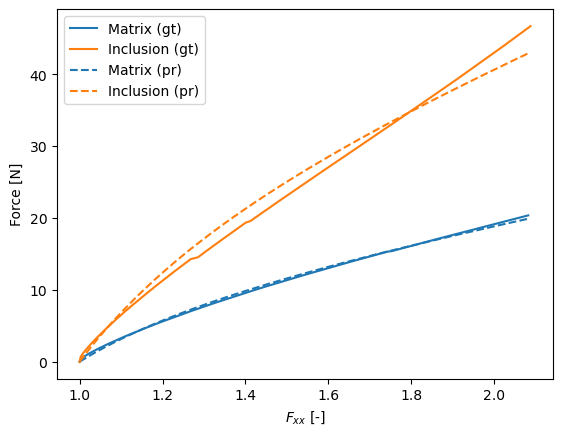

In [35]:
# Test
P_pr_incl = get_neohook_vmap(ugrad_incl, params_incl)
P_pr_mtrx = get_neohook_vmap(ugrad_mtrx, params_mtrx)

fig, ax = plt.subplots()
ax.plot(F_hist_mtrx[:,1,1], force_mtrx, label='Matrix (gt)', color='tab:blue')
ax.plot(F_hist_incl[:,1,1], force_incl, label='Inclusion (gt)', color='tab:orange')

ax.plot(F_hist_mtrx[:,1,1], P_pr_mtrx, label='Matrix (pr)', color='tab:blue', linestyle='--')
ax.plot(F_hist_incl[:,1,1], P_pr_incl, label='Inclusion (pr)', color='tab:orange', linestyle='--')
ax.set(xlabel='$F_{xx}$ [-]', ylabel='Force [N]')
ax.legend(); 

## 1. Generate data + pretraining

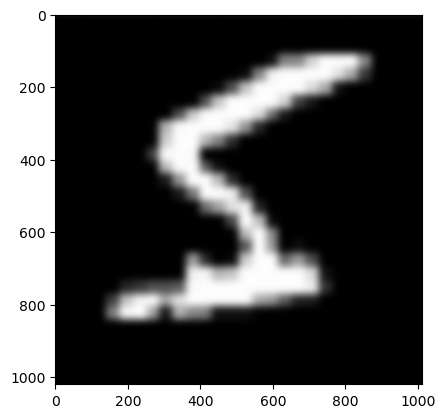

In [48]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)
Nx, Ny = 100, 100
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])
image = Image.open('data/mnist_S.png')
image = image.filter(ImageFilter.GaussianBlur(radius=10))
plt.imshow(image)
image = image.rotate(-90)
image = np.array(image)
image = image.mean(axis=2)
image = image/image.max()

pts_x = np.linspace(0,1,image.shape[0])
pts_y = np.linspace(0,1,image.shape[1])

def coords_2_params_gt(xy):
    x, y = xy
    c = interp2d(x,y,pts_x,pts_y,image)
    return params_mtrx + c*(params_incl-params_mtrx)

In [49]:
neohook_P_vmap = vmap(ThreeDElasticity(neohook_model).ugrad_2_P, in_axes=(0, 0, None))
class HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: ThreeDElasticity(neohook_model).ugrad_2_P(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [55]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 50, 50
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.05544, 1.07795, 1.10065, 1.12326, 1.14587]
n_elem = Nx*Ny
F_hist_goh = []
P_hist_goh = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,         top,                                     ],
        [1,              1,                                       ],
        [zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    # params = vmap(coords_2_params_gt)(elem_X)
    params = []
    for xy in elem_X:
        params.append(coords_2_params_gt(xy))
    params = np.expand_dims(params, 1)
    params_vec = jnp.repeat(params, axis=1, repeats=4)
    problem.set_params(params_vec)


    u = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(u), axis=1)
    F = u_grad + np.eye(2)

    P = neohook_P_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist_goh.append(F)
    P_hist_goh.append(P)
F_hist_goh = np.array(F_hist_goh)
P_hist_goh = np.array(P_hist_goh)

[05-27 23:17:12][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[05-27 23:17:12][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[05-27 23:17:12][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[05-27 23:17:13][DEBUG] jax_fem: Done pre-computations, took 0.22852778434753418 [s]
[05-27 23:17:13][INFO] jax_fem: Solving a problem with 2500 cells, 2601x2 = 5202 dofs.
[05-27 23:17:13][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[05-27 23:17:13][DEBUG] jax_fem: Start timing
[05-27 23:17:13][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[05-27 23:17:14][DEBUG] jax_fem: Function split_and_compute_cell took 0.6736 seconds
[05-27 23:17:14][DEBUG] jax_fem: Creating sparse matrix with scipy...
[05-27 23:17:14][DEBUG] jax_fem: Linear guess solve...
[05-27 23:17:14][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[05-27 23:17:14][DEBUG] jax_fem: PE

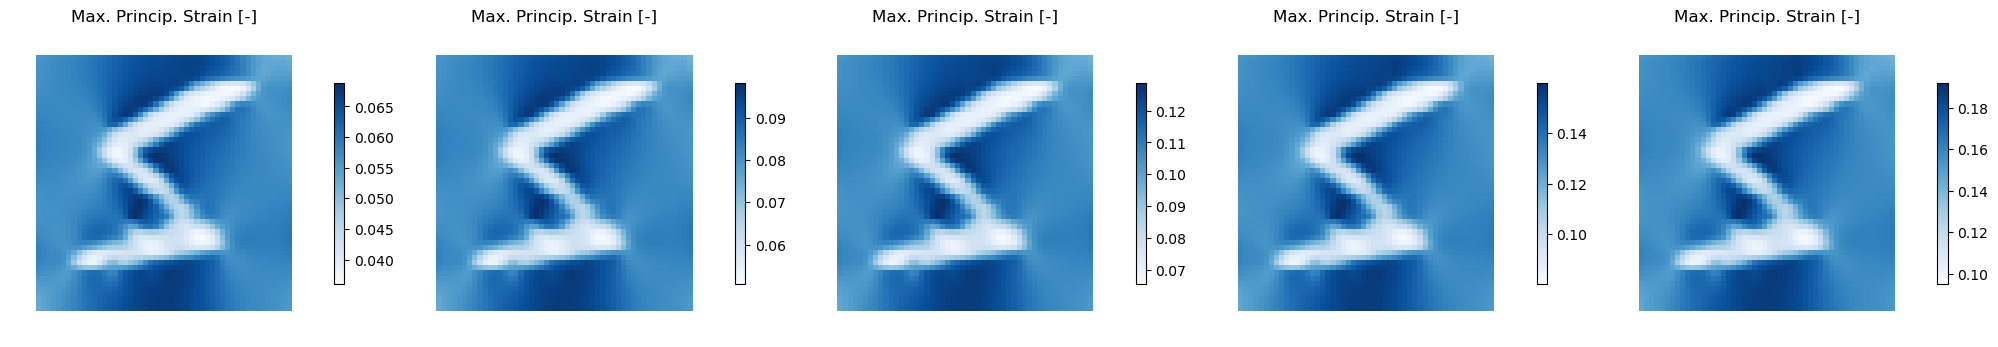

In [57]:
fig, axes = plt.subplots(1,5,figsize=(25,5))
strains = []
t_hist = np.arange(len(lmb_hist))
for t, F, P, ax in zip(t_hist, F_hist_goh, P_hist_goh, axes):
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T

    mps = np.maximum(E_11, E_22)
    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax, ec='none'); 

    strains.append(np.array([t*np.ones(len(F)), F[:,0,0], F[:,0,1], F[:,1,0], F[:,1,1]]))
strains = np.hstack(strains)

### Coords_2_strain NN

In [59]:
# instead of using a 2D spline, use a NN to get the strain field for a given (x,y)
def loss_coords_2_strain(params, X, key):
    inp, out_gt = X[:,:3], X[:,3:] #inp: x,y,lmb and out_gt=eps_xx, eps_yy
    t = inp[:,2:3]
    out_pr = coords_2_strain_nn(inp, params)
    out_gt = out_gt/(t+1) #dividing by t+1 just for some regularization
    out_pr = out_pr/(t+1) #dividing by t+1 just for some regularization
    return jnp.mean((out_pr-out_gt)**2)

n_ff = 40 # 10 cosines and 10 sines in the fourier features
n_inp = 2 # x, y
ff_params = np.random.normal(size=n_inp*n_ff).reshape([n_inp,n_ff])*0.5
nn_layers = [2*n_ff+1,40,40,4]
nn_params = init_params_nn(nn_layers, key)
coord_2_strain_params = [ff_params, nn_params]

opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(coord_2_strain_params)

X = np.vstack([elem_X, elem_X, elem_X, elem_X, elem_X])
inp = np.hstack([X, strains.T])
coord_2_strain_params, train_loss, _ = train(loss_coords_2_strain, inp, get_params, opt_update, opt_state, key, nIter = 100000, print_freq=1000, batch_size=1000)

it 1000, train loss = 7.462469e-05
it 2000, train loss = 2.627407e-05
it 3000, train loss = 1.298805e-05
it 4000, train loss = 8.196852e-06
it 5000, train loss = 6.524064e-06
it 6000, train loss = 4.800278e-06
it 7000, train loss = 4.622470e-06
it 8000, train loss = 4.547216e-06
it 9000, train loss = 3.256115e-06
it 10000, train loss = 3.285351e-06
it 11000, train loss = 3.557080e-06
it 12000, train loss = 2.792895e-06
it 13000, train loss = 2.741370e-06
it 14000, train loss = 2.416180e-06
it 15000, train loss = 3.416450e-06
it 16000, train loss = 2.222377e-06
it 17000, train loss = 2.202522e-06
it 18000, train loss = 1.939010e-06
it 19000, train loss = 2.888774e-06
it 20000, train loss = 1.673202e-06
it 21000, train loss = 1.664736e-06
it 22000, train loss = 1.654547e-06
it 23000, train loss = 1.460064e-06
it 24000, train loss = 1.628726e-06
it 25000, train loss = 1.656630e-06
it 26000, train loss = 2.537009e-06
it 27000, train loss = 2.322766e-06
it 28000, train loss = 2.022339e-06
i

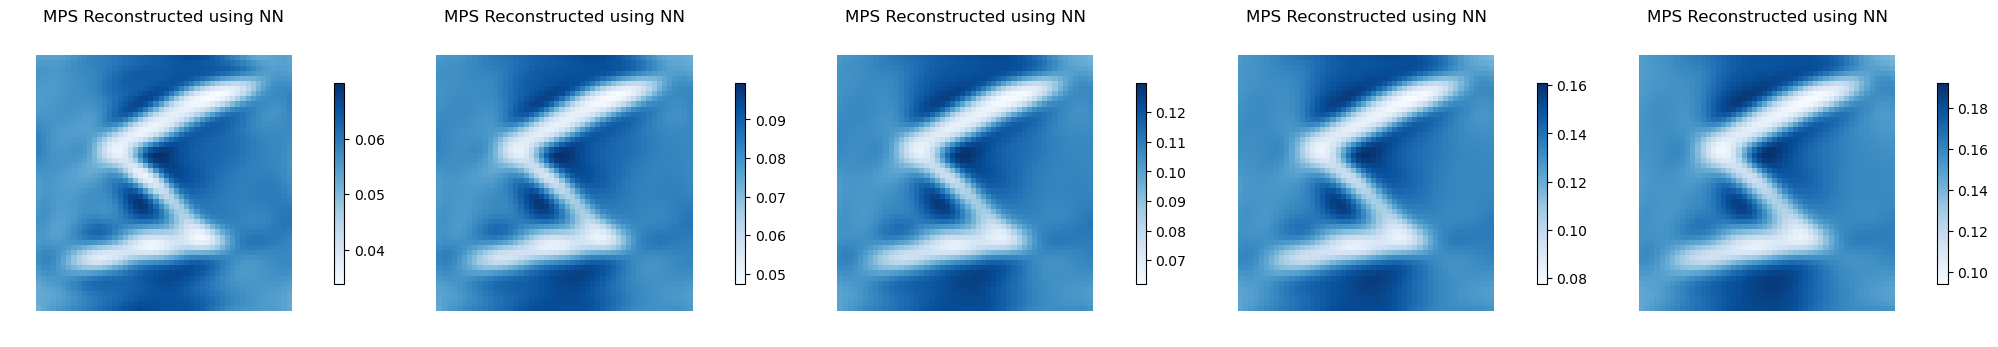

In [61]:
fig, axes = plt.subplots(1,5,figsize=(25,4))
for t in t_hist:
    ax = axes[t]
    aux = np.hstack([elem_X, t*np.ones_like(elem_X[:,:1])])
    F_xx, F_xy, F_yx, F_yy = coords_2_strain_nn(aux, coord_2_strain_params).T
    F = np.stack([F_xx, F_xy, F_yx, F_yy]).T.reshape([-1,2,2])
    
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T
    mps = np.maximum(E_11, E_22)

    plotmesh(mesh.cells, mesh.points, mps, title='MPS Reconstructed using NN', ax=ax, ec='none'); 

In [62]:
# identify the boundaries
rgt_bd_elems = []
top_bd_elems = []
lft_bd_elems = []
bot_bd_elems = []
for i, e in enumerate(mesh.cells):
    if any([mesh.points[e[i],0]>0.99 for i in range(4)]):
        rgt_bd_elems.append(i)
    if any([mesh.points[e[i],1]>0.99 for i in range(4)]):
        top_bd_elems.append(i)
    if any([mesh.points[e[i],0]<0.01 for i in range(4)]):
        lft_bd_elems.append(i)
    if any([mesh.points[e[i],1]<0.01 for i in range(4)]):
        bot_bd_elems.append(i)

# get the reaction forces by integrating the stresses of the boundary elements
rgt_bd_frc = np.sum(P_hist_goh[:,rgt_bd_elems,0,0], axis=1)
lft_bd_frc = np.sum(P_hist_goh[:,lft_bd_elems,0,0], axis=1)
top_bd_frc = np.sum(P_hist_goh[:,top_bd_elems,1,1], axis=1)
bot_bd_frc = np.sum(P_hist_goh[:,bot_bd_elems,1,1], axis=1)
Force_x = jnp.array(0.5*(rgt_bd_frc + lft_bd_frc))
Force_y = jnp.array(0.5*(top_bd_frc + bot_bd_frc))

# get the center points of the elements
rgt_bd_X = elem_X[rgt_bd_elems]
top_bd_X = elem_X[top_bd_elems]
lft_bd_X = elem_X[lft_bd_elems]
bot_bd_X = elem_X[bot_bd_elems]
bd_X = rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X

In [63]:
# Homogenize the strains
F_xx_mean = np.mean(F_hist_goh[:,:,0,0], axis=1)
F_xy_mean = np.mean(F_hist_goh[:,:,0,1], axis=1)
F_yx_mean = np.mean(F_hist_goh[:,:,1,0], axis=1)
F_yy_mean = np.mean(F_hist_goh[:,:,1,1], axis=1)

P_xx_mean = Force_x/len(rgt_bd_elems)
P_yy_mean = Force_y/len(top_bd_elems)
inputs = np.array([F_xx_mean, F_xy_mean, F_yx_mean, F_yy_mean, P_xx_mean, P_yy_mean]).T

n_neurons = 4
# Define the loss function for when training all params
@jit
def loss_stress(params, x, key):
    model = NODE_model_aniso(params)
    F_xx, F_xy, F_yx, F_yy, P_xx_gt, P_yy_gt = x.T
    P = eval_P_vmap(F_xx, F_xy, F_yx, F_yy, model)
    P_xx_pr, P_yy_pr = P[:,0,0], P[:,1,1]
    return np.mean((P_xx_pr-P_xx_gt)**2+(P_yy_pr-P_yy_gt)**2)

# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, n_neurons, n_neurons]
sample_layers = [n_neurons,1]
node_params = init_params_aniso(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(node_params)

# Train
node_params, train_loss, _ = train(loss_stress, inputs, get_params, opt_update, opt_state, key, nIter = 20000, print_freq=1000)

it 1000, train loss = 9.007232e-02
it 2000, train loss = 2.328298e-02
it 3000, train loss = 1.074891e-02
it 4000, train loss = 6.277487e-03
it 5000, train loss = 3.778966e-03
it 6000, train loss = 2.137340e-03
it 7000, train loss = 1.132992e-03
it 8000, train loss = 5.880781e-04
it 9000, train loss = 3.104890e-04
it 10000, train loss = 1.687374e-04
it 11000, train loss = 9.509985e-05
it 12000, train loss = 5.685122e-05
it 13000, train loss = 3.747757e-05
it 14000, train loss = 2.790665e-05
it 15000, train loss = 2.295376e-05
it 16000, train loss = 2.023841e-05
it 17000, train loss = 1.869187e-05
it 18000, train loss = 1.782865e-05
it 19000, train loss = 1.739859e-05
it 20000, train loss = 1.720608e-05


In [64]:
mymodel = NODE_model_aniso(node_params)
P = eval_P_vmap(F_xx_mean, F_xy_mean, F_yx_mean, F_yy_mean, mymodel)
P_xx_pr, P_yy_pr = P[:,0,0], P[:,1,1]
print('gt P_xx & P_yy: ', P_xx_mean, P_yy_mean)
print('pr P_xx & P_yy: ', P_xx_pr, P_yy_pr)

gt P_xx & P_yy:  [0. 0. 0. 0. 0.] [2.21665 3.05387 3.8659  4.6451  5.39709]
pr P_xx & P_yy:  [0.00094 0.00169 0.00263 0.00372 0.00499] [2.21397 3.05792 3.86625 4.64178 5.39849]


In [65]:
# Fit a function Λ that maps x,y ∈ [0,1] to the individual-specific parameters of this NODE with a maximum variance of, say, 1%
phi, unravel = ravel_pytree(node_params)
n_phi = len(phi)

# ff_params = coord_2_strain_params[0]
# ff_nn2 = lambda x, nn_params: ff_nn(x, [ff_params, nn_params])
def loss_Lambda(params, inp, key):
    out_pr = ff_nn(inp, params)
    return jnp.mean((out_pr-phi)**2)

n_ff = 40
ff_params = np.random.normal(size=2*n_ff).reshape([2,n_ff])
nn_layers = [2*n_ff,40,40,n_phi]
nn_params = init_params_nn(nn_layers, key)
Lambda_params = [ff_params, nn_params]
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(Lambda_params)

inp = np.array(np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,20))).reshape([2,-1]).T
Lambda_params, train_loss, _ = train(loss_Lambda, inp, get_params, opt_update, opt_state, key, nIter = 5000, print_freq=1000)

it 1000, train loss = 1.030623e-04
it 2000, train loss = 3.059813e-05
it 3000, train loss = 1.300459e-05
it 4000, train loss = 6.391827e-06
it 5000, train loss = 3.413712e-06


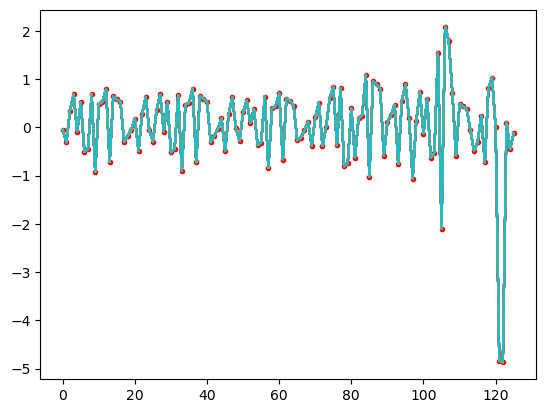

In [66]:
fig, ax = plt.subplots()
ax.plot(phi, 'r.-')
for y in np.linspace(0,1,4):
    for x in np.linspace(0,1,10):
        params = ff_nn(np.array([x,y]).reshape([1,-1]), Lambda_params)
        ax.plot(params[0])

In [67]:
with open('params/mnist_S_data_uni_y_pre.npy', 'wb') as f:
    pickle.dump([coord_2_strain_params, node_params, Lambda_params, mesh, elem_X, Force_x, Force_y, strains,
                 bd_X, lmb_hist, P_hist_goh, F_hist_goh, t_hist], f)

## 2. Retrain

In [68]:
with open('params/mnist_S_data_uni_y_pre.npy', 'rb') as f:
    coord_2_strain_params, node_params, Lambda_params, mesh, elem_X, Force_x, Force_y, strains, \
                 bd_X, lmb_hist, P_hist_goh, F_hist_goh, t_hist = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

In [69]:
# Train
a1 = 10000
@jit
def loss(Lambda_params, XYt_colloc):
    Div_x, Div_y = divergence(Lambda_params, XYt_colloc, coord_2_strain_params, NODE_w_unravel)
    loss_Div = a1*(Div_x**2 + Div_y**2)

    def bd_forces_loss(_, t):
        F_rgt, F_top, F_lft, F_bot = bd_forces(Lambda_params, t, bd_X, coord_2_strain_params, NODE_w_unravel)
        Fx = Force_x[jnp.array(t, int)]
        Fy = Force_y[jnp.array(t, int)]
        return None, a2*((F_rgt-Fx)**2 + (F_top-Fy)**2 + (F_lft-Fx)**2 + (F_bot-Fy)**2)
    loss_F = jnp.mean(scan(bd_forces_loss, init=None, xs=t_hist)[1])
    # loss_F = 0.0
    
    return loss_Div + loss_F

lr = 1e-4
sharding = PositionalSharding(jax.devices()).reshape(n_cores, 1)
opt_init, opt_update, get_params = optimizers.adam(lr) 
opt_state = opt_init(Lambda_params)

node_X_ext = jnp.hstack([mesh.points, t_hist[-1]*np.ones_like(mesh.points[:,:1])])
metric1 = lambda params, X:  bd_forces(params, t_hist[-1], bd_X, coord_2_strain_params, NODE_w_unravel)
metric2 = lambda params, X: divergence(params, node_X_ext, coord_2_strain_params, NODE_w_unravel)

Lambda_params, val_loss, metrics = train_colloc(loss, [mesh.points, t_hist], get_params, opt_update, opt_state, 
                                            key, sharding, 'cross', nIter = 40000, print_freq=1000, batch_size=1000)

with open('params/mnist_S_data_uni_y_post.npy', 'wb') as f:
    pickle.dump([mesh, elem_X, strains, Force_x, Force_y, node_params, Lambda_params, val_loss, metrics, t_hist, lmb_hist], f)

it 1, val loss = 1.900830e+01
it 1001, val loss = 5.911965e+01
it 2001, val loss = 5.662973e+01
it 3001, val loss = 8.679286e+01
it 4001, val loss = 5.335723e+00
it 5001, val loss = 6.406109e+00
it 6001, val loss = 1.184021e+01
it 7001, val loss = 7.050457e+00
it 8001, val loss = 2.008196e+00
it 9001, val loss = 2.494173e+00
it 10001, val loss = 3.773665e+00
it 11001, val loss = 4.738415e+00
it 12001, val loss = 2.108031e+01
it 13001, val loss = 1.800180e+00
it 14001, val loss = 3.208071e+00
it 15001, val loss = 1.383930e+01
it 16001, val loss = 1.016961e+00
it 17001, val loss = 3.983810e+00
it 18001, val loss = 1.735631e+00
it 19001, val loss = 2.372560e+00
it 20001, val loss = 8.727190e-01
it 21001, val loss = 2.454113e+00
it 22001, val loss = 3.601857e+00
it 23001, val loss = 5.487560e+00
it 24001, val loss = 5.259990e+00
it 25001, val loss = 7.582661e+00
it 26001, val loss = 2.922598e+00
it 27001, val loss = 2.042416e+01
it 28001, val loss = 2.707254e+00
it 29001, val loss = 3.8059

## 3. Test

In [70]:
with open('params/mnist_S_data_uni_y_post.npy', 'rb') as f:
    mesh, elem_X, strains, Force_x, Force_y, node_params, Lambda_params, val_loss, metrics, t_hist, lmb_hist = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

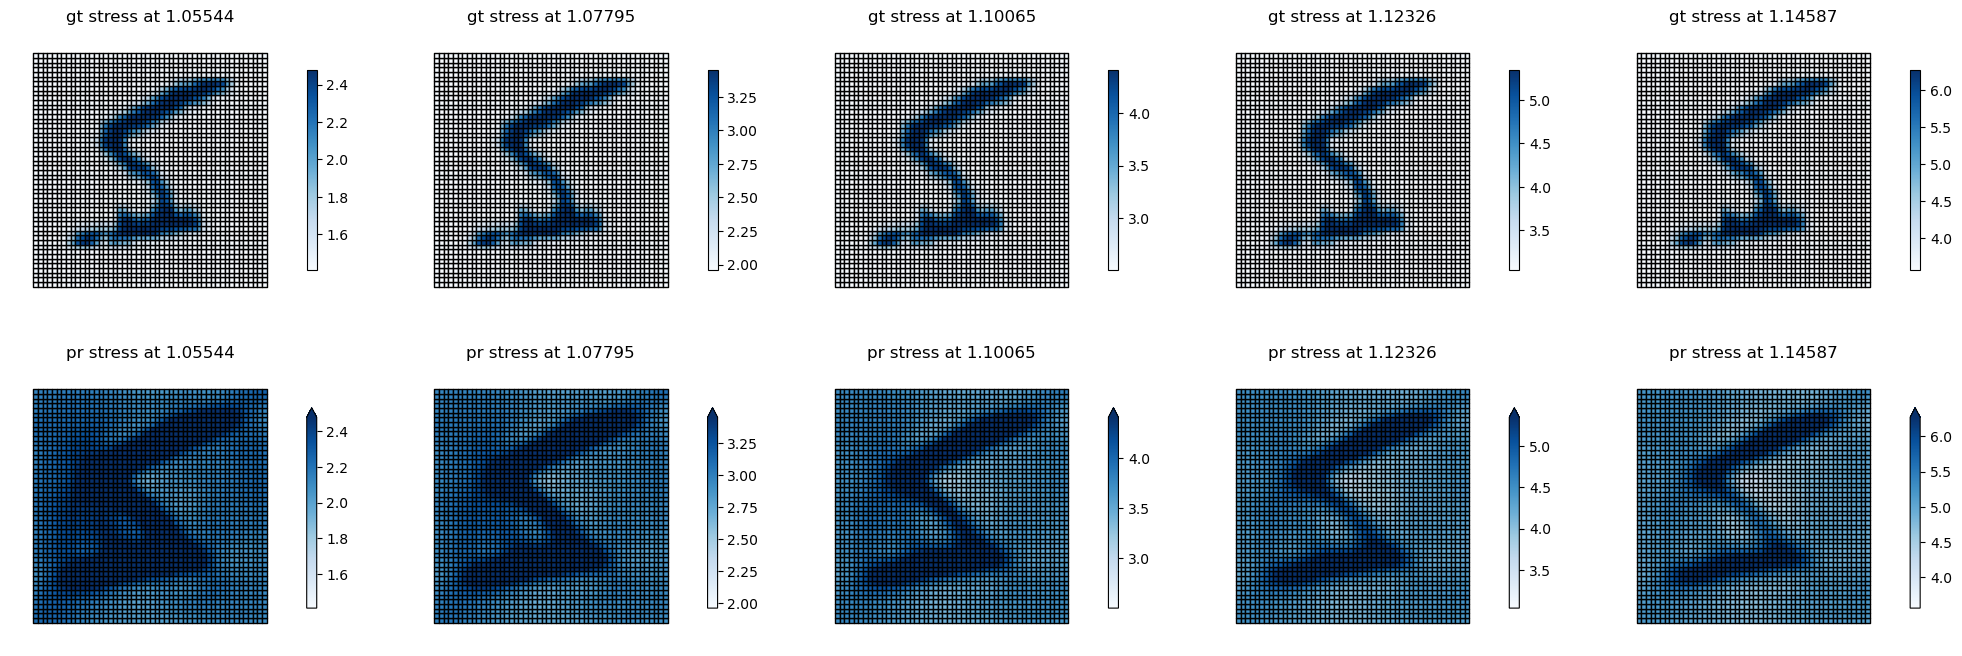

In [72]:
# Stiffness across the domain
fig, axes = plt.subplots(2,5,figsize=(25,8))
for lmb, ax in zip(lmb_hist, axes.T):
    lmbx = 1.0/lmb
    ugrad = jnp.array([[lmbx-1.0, 0.0], [0.0, lmb-1.0]])

    params_gt = []
    for xy in elem_X:
        params_gt.append(coords_2_params_gt(xy))
    params_gt = np.array(params_gt)
    params_pr = ff_nn(elem_X, Lambda_params)

    c_elem_gt = []
    c_elem_pr = []
    for params_gt_i, params_pr_i in zip(params_gt, params_pr):
        c_elem_gt.append(ThreeDElasticity(neohook_model).ugrad_2_P(ugrad, params_gt_i, 2)[1,1])
        c_elem_pr.append(ThreeDElasticity(NODE_w_unravel).ugrad_2_P(ugrad, params_pr_i, 2)[1,1])
    
    plotmesh(mesh.cells, mesh.points, c_elem_gt, title='gt stress at {}'.format(str(lmb)), ax=ax[0]); 
    extent = [np.min(c_elem_gt), np.max(c_elem_gt)]
    if extent[0] > np.min(c_elem_pr) and extent[1] < np.max(c_elem_pr):
        extend='both'
    elif extent[0] > np.min(c_elem_pr):
        extend='min'
    elif extent[1] < np.max(c_elem_pr):
        extend='max'
    plotmesh(mesh.cells, mesh.points, c_elem_pr, title='pr stress at {}'.format(str(lmb)), ax=ax[1], extent=extent, extend=extend); 

In [4]:
P_vmap = vmap(ThreeDElasticity(NODE_w_unravel).ugrad_2_P, in_axes=(0, 0, None))
class HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: ThreeDElasticity(NODE_w_unravel).ugrad_2_P(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [5]:
params_vec = []
for x, y in elem_X:
    Lambda_inp = np.array([x,y]).reshape([-1,2])
    phi = ff_nn(Lambda_inp, Lambda_params).flatten()
    params_vec.append(phi)
params_vec = jnp.array(params_vec).reshape([len(params_vec),1,-1])
params_vec = jnp.repeat(params_vec, axis=1, repeats=4)

In [6]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.05, 1.10, 1.15, 1.20]
n_elem = Nx*Ny
C10 = jnp.zeros(n_elem)
k1  = jnp.zeros(n_elem)
k2  = jnp.zeros(n_elem)
F_hist = []
node_x_hist = []
P_hist = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    P = P_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist.append(F)
    node_x_hist.append(node_x)
    P_hist.append(P)
node_x_hist = np.array(node_x_hist)
F_hist = np.array(F_hist)
P_hist = np.array(P_hist)

[01-29 12:02:18][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[01-29 12:02:18][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[01-29 12:02:18][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[01-29 12:02:19][DEBUG] jax_fem: Done pre-computations, took 0.3462047576904297 [s]
[01-29 12:02:19][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[01-29 12:02:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-29 12:02:19][DEBUG] jax_fem: Start timing
[01-29 12:02:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-29 12:02:22][DEBUG] jax_fem: Function split_and_compute_cell took 2.7130 seconds
[01-29 12:02:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-29 12:02:22][DEBUG] jax_fem: Linear guess solve...
[01-29 12:02:22][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[01-29 12:02:22][DEBUG] jax_fem: PETSc 

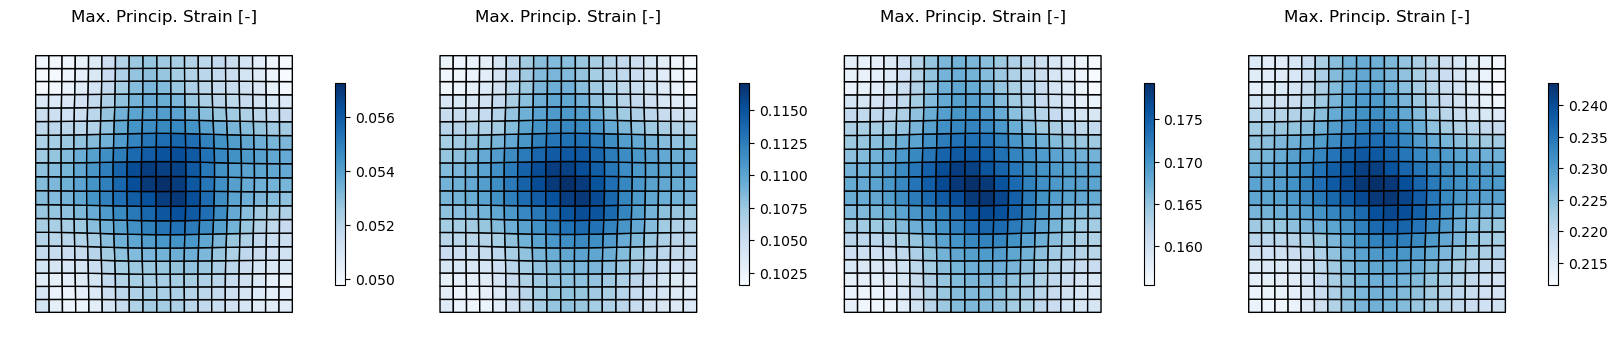

In [8]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
t_hist = np.arange(len(lmb_hist))
for t, node_x, F, ax in zip(t_hist, node_x_hist, F_hist, axes):
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T

    mps = np.maximum(E_11, E_22)
    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 